1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
MINIMUM MODULI


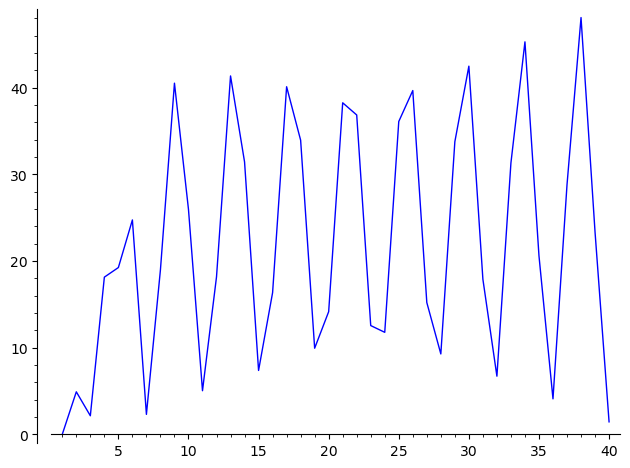

LOGS MINIMUM MODULI


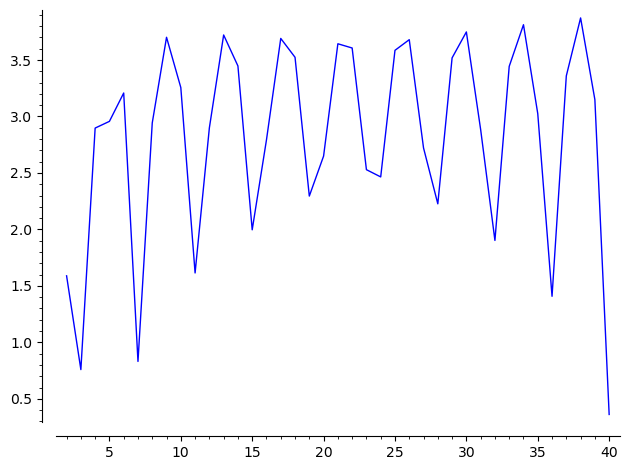

minimum logarithm of minimum modulus: 0.36134944845140652585978202382
Data range: n = 2 to 40
Number of data points: 39
Min modulus range: 1.435265 to 48.074111
Log min modulus range: 0.361349 to 3.872744

Polynomial trend coefficients: [-0.00301728  0.13817333  1.62446964]
Detrended data std dev: 0.8312

TOP DOMINANT PERIODICITIES (in index n)
Rank   Period       Frequency    Power          
----------------------------------------------------------------------
1            4.33   0.230769     1.95e+02


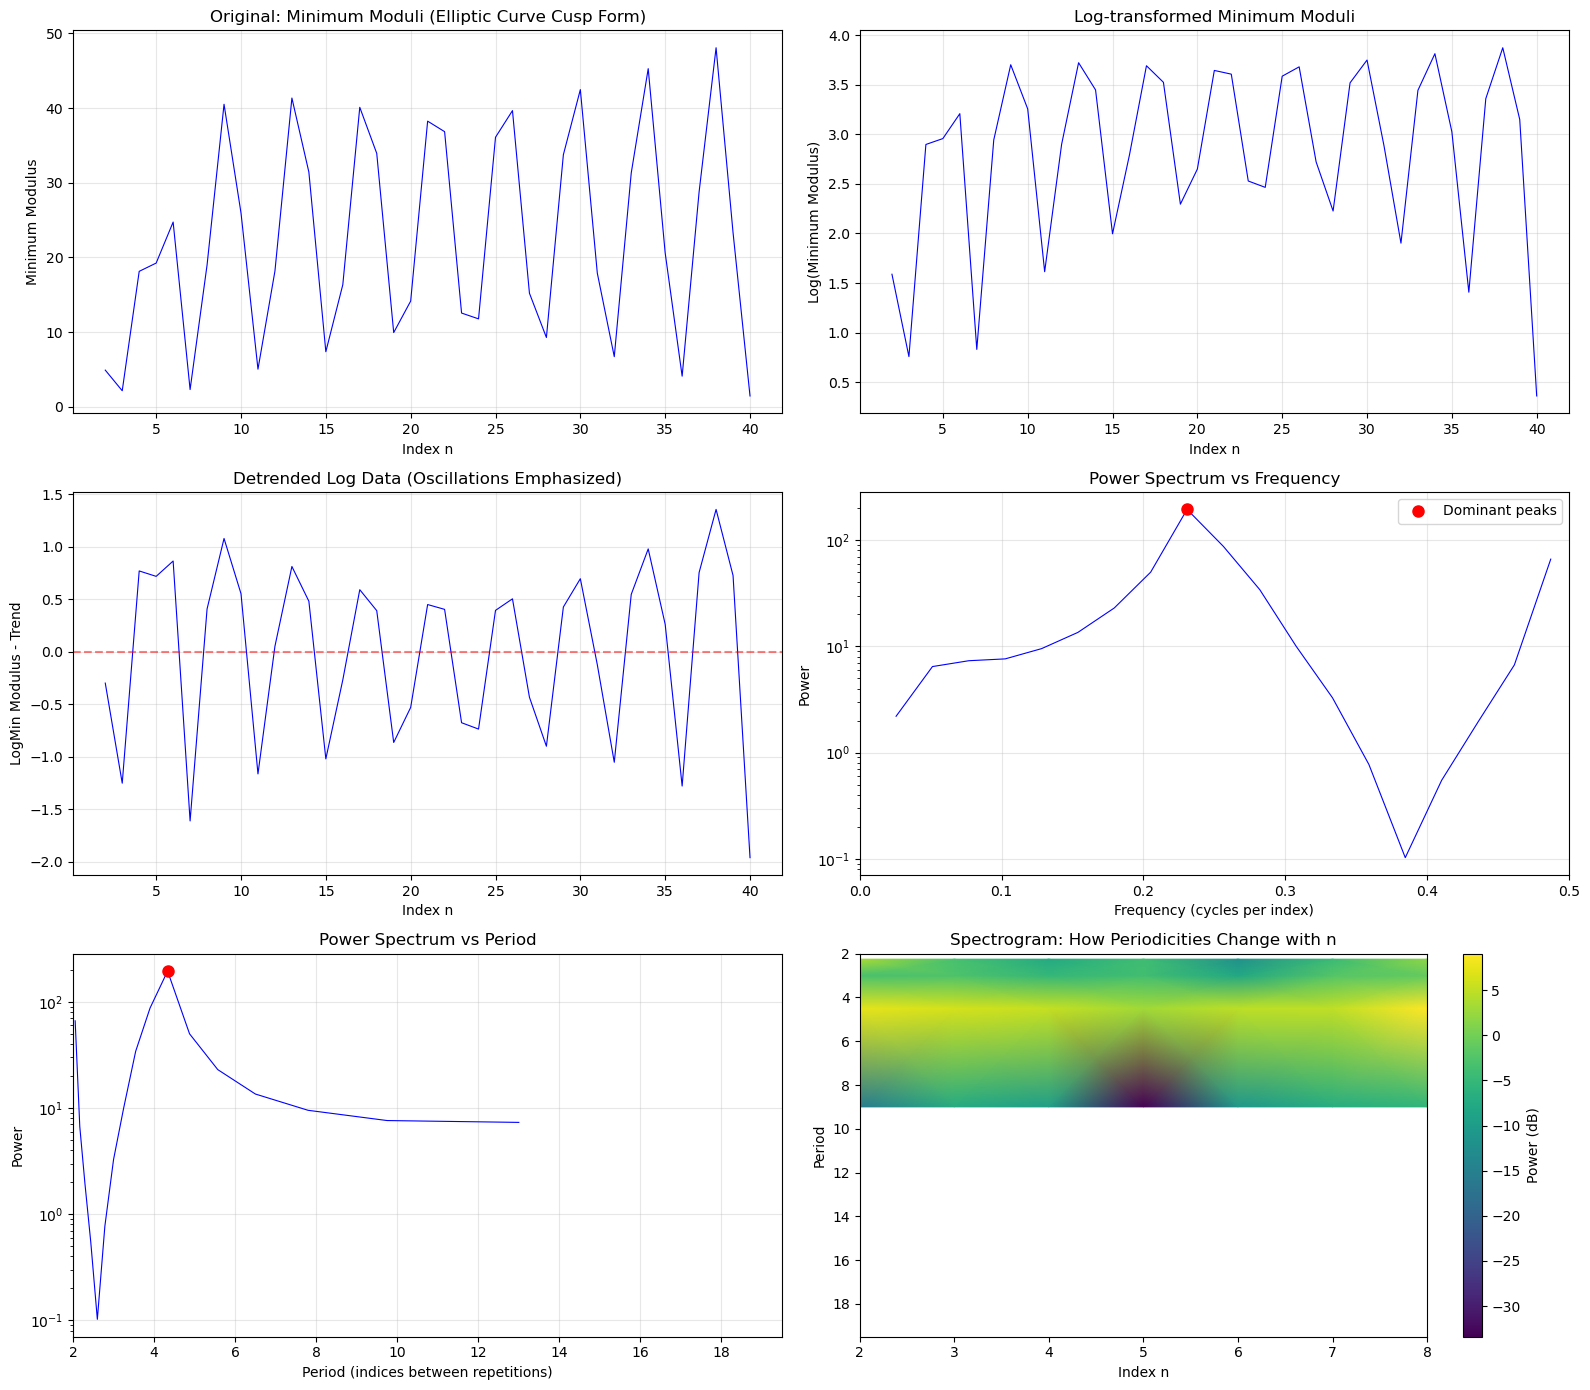


Analysis complete! Examine the plots and frequency table above.


In [6]:
import pickle
from sage.all import sigma, nth_prime, matrix, flatten, QQ
import ast
import time

start=time.time()
precision_bits=100
def tau(n):
    def step1(n, k):
        return 35*k^4 - 52*k^3*n + 18*k^2*n^2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans += step1(n, k) * step2(n, k)
        return 24*ans
    return n^4 * sigma(n) - step3(n)

def tau_prime(k):
    pn = nth_prime(k)
    return tau(pn)

tau_prime_list = [] 
for k in range(1, 501):
    tau_prime_list.append([k, tau_prime(k)])
    
c = 0
h_list = [[0, 1]] + tau_prime_list 
j_list = [(0, c)]
for n in range(1,500):
    sm = 0
    for r in range(1, n): 
        sm = sm + j_list[r][1] * h_list[n-r][1] 
    j_n = n * h_list[n][1] - sm
    j_list.append((n, j_n))
    
def P_matrix(lst):
    lenlist = len(lst)
    columns = [lst]
    for k in range(1, lenlist):
        column = [0]*(k-1)
        column = column + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:lenlist]
        columns += [column]
    return (matrix(columns)).transpose()

# Create polynomial ring for Lagrange interpolation
R = QQ['x']
CC = ComplexField(precision_bits)
x = polygen(QQ)  # Can remain in preamble if all polynomials are in one variable
charpol_list=[]
roots_list=[]
mins_list=[]
log_mins_list=[]

for n in range(1, 41):
    print(n)
    deformed_j_list=j_list[:n]
    inputs=[pair[1] for pair in deformed_j_list]
    pl=P_matrix(inputs) 
    det=pl.det()
    cp=pl.charpoly()
    charpol_list.append((n,cp))
    roots = cp.roots(ring=CC, multiplicities=False)       
    roots_list.append((n,roots))
    aar = [r.abs() for r in roots]
    if aar!=[]:
        minn = min(aar)  
        mins_list.append((n,minn))
        if minn>0:
            log_minn=log(minn)
            log_mins_list.append((n,log_minn))

p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
print("MINIMUM MODULI")
p.show()
p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
print("LOGS MINIMUM MODULI")
p.show()
mml=[pair[1] for pair in log_mins_list]
print("minimum logarithm of minimum modulus:",min(mml))



with open('/Users/barrybrent/data2/run3feb26no1.txt', 'wb') as wfile:
    pickle.dump(roots_list, wfile) # ouput snipped


with open('/Users/barrybrent/data2/run3feb26no3.txt', 'wb') as wfile:
    pickle.dump(mins_list, wfile) # ouput snipped

with open('/Users/barrybrent/data2/run3feb6no4.txt', 'wb') as wfile:
    pickle.dump(log_mins_list, wfile) # ouput snipped

# FOURIER ANALYSIS OF MINIMUM MODULI - Elliptic Curve Cusp Form
# This cell performs spectral analysis on the minimum moduli sequence
# to detect periodicities, dominant frequencies, and oscillatory patterns

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PREPARE THE DATA - Convert from SageMath to Python/NumPy types
# ==============================================================================

# Extract the data from mins_list and convert to Python floats
# This is crucial because SageMath uses its own numeric types
indices = np.array([float(pair[0]) for pair in mins_list], dtype=np.float64)
minmoduli = np.array([float(pair[1]) for pair in mins_list], dtype=np.float64)

# Mask out zeros so logs are finite
mask = minmoduli > 0
indices = indices[mask]
minmoduli = minmoduli[mask]
logminmoduli = np.log(minmoduli)

print(f"Data range: n = {int(indices[0])} to {int(indices[-1])}")
print(f"Number of data points: {len(indices)}")
print(f"Min modulus range: {minmoduli.min():.6f} to {minmoduli.max():.6f}")
print(f"Log min modulus range: {logminmoduli.min():.6f} to {logminmoduli.max():.6f}")

# ==============================================================================
# 2. DETRENDING (Important for seeing oscillations)
# ==============================================================================

# For the log data, remove any polynomial trend to focus on oscillations
# We'll try both linear and quadratic detrending

# Linear detrend
log_detrended_linear = signal.detrend(logminmoduli, type='linear')

# Polynomial detrend (degree 2) - captures parabolic growth
poly_coeffs = np.polyfit(indices, logminmoduli, deg=2)
poly_trend = np.polyval(poly_coeffs, indices)
log_detrended_poly = logminmoduli - poly_trend

print(f"\nPolynomial trend coefficients: {poly_coeffs}")
print(f"Detrended data std dev: {np.std(log_detrended_poly):.4f}")

# ==============================================================================
# 3. COMPUTE FOURIER TRANSFORM
# ==============================================================================

# Use FFT on the detrended log data
# The FFT reveals which "frequencies" (periodicities in n) are present

fft_result = np.fft.fft(log_detrended_poly)
fft_frequencies = np.fft.fftfreq(len(indices), d=1.0)  # d=1 means indices are spaced by 1

# Power spectrum (magnitude squared)
power_spectrum = np.abs(fft_result)**2

# Only keep positive frequencies (negative are redundant for real signals)
positive_freq_mask = fft_frequencies > 0
frequencies = fft_frequencies[positive_freq_mask]
power = power_spectrum[positive_freq_mask]

# Convert frequency to period: period = 1/frequency
# (period tells us "spikes repeat every X indices")
periods = 1.0 / frequencies

# ==============================================================================
# 4. IDENTIFY DOMINANT FREQUENCIES
# ==============================================================================

# Find peaks in the power spectrum
# Lower threshold to catch more peaks since we have more data (n up to 400)
peak_indices = signal.find_peaks(power, height=np.max(power)*0.05)[0]  # peaks at least 5% of max
peak_powers = power[peak_indices]
peak_periods = periods[peak_indices]

# Sort by power (strongest first)
sorted_indices = np.argsort(peak_powers)[::-1]
top_peaks = sorted_indices[:min(15, len(sorted_indices))]  # Show top 15

print("\n" + "="*70)
print("TOP DOMINANT PERIODICITIES (in index n)")
print("="*70)
print(f"{'Rank':<6} {'Period':<12} {'Frequency':<12} {'Power':<15}")
print("-"*70)
for rank, idx in enumerate(top_peaks, 1):
    period = peak_periods[idx]
    freq = frequencies[peak_indices[idx]]
    pwr = peak_powers[idx]
    print(f"{rank:<6} {period:>10.2f} {freq:>10.6f} {pwr:>12.2e}")

# ==============================================================================
# 5. VISUALIZATIONS
# ==============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 5.1: Original data (linear scale)
axes[0, 0].plot(indices, minmoduli, 'b-', linewidth=0.8)
axes[0, 0].set_xlabel('Index n')
axes[0, 0].set_ylabel('Minimum Modulus')
axes[0, 0].set_title('Original: Minimum Moduli (Elliptic Curve Cusp Form)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 5.2: Log scale data
axes[0, 1].plot(indices, logminmoduli, 'b-', linewidth=0.8)
axes[0, 1].set_xlabel('Index n')
axes[0, 1].set_ylabel('Log(Minimum Modulus)')
axes[0, 1].set_title('Log-transformed Minimum Moduli')
axes[0, 1].grid(True, alpha=0.3)

# Plot 5.3: Detrended data (shows oscillations more clearly)
axes[1, 0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8)
axes[1, 0].set_xlabel('Index n')
axes[1, 0].set_ylabel('LogMin Modulus - Trend')
axes[1, 0].set_title('Detrended Log Data (Oscillations Emphasized)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 5.4: Power Spectrum vs Frequency
axes[1, 1].semilogy(frequencies, power, 'b-', linewidth=0.8)
axes[1, 1].semilogy(frequencies[peak_indices[top_peaks]],
                    peak_powers[top_peaks],
                    'ro', markersize=8, label='Dominant peaks')
axes[1, 1].set_xlabel('Frequency (cycles per index)')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('Power Spectrum vs Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 0.5)  # Nyquist limit

# Plot 5.5: Power Spectrum vs Period (often more intuitive)
maxperiod = len(indices) / 2  # Only plot periods up to half the data length
periodmask = periods < maxperiod
axes[2, 0].semilogy(periods[periodmask], power[periodmask], 'b-', linewidth=0.8)

# Mark dominant periods
for idx in top_peaks:
    if peak_periods[idx] < maxperiod:
        axes[2, 0].semilogy(peak_periods[idx], peak_powers[idx],
                            'ro', markersize=8)

axes[2, 0].set_xlabel('Period (indices between repetitions)')
axes[2, 0].set_ylabel('Power')
axes[2, 0].set_title('Power Spectrum vs Period')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_xlim(2, maxperiod)

# Plot 5.6: Spectrogram (time-frequency analysis using Short-Time Fourier Transform)
# This shows if periodicities change over the sequence
window_size = min(128, len(indices)//4)  # adaptive window size, larger for more data
fspec, tspec, Sxx = signal.spectrogram(log_detrended_poly, fs=1.0,
                                       nperseg=window_size,
                                       noverlap=window_size//2)

# Convert frequency axis to period for easier interpretation
periodspec = 1.0 / (fspec + 1e-10)  # avoid division by zero
periodspec = periodspec[1:]  # remove DC component
Sxx = Sxx[1:, :]

# Plot with period on y-axis, inverted so small periods at bottom
im = axes[2, 1].pcolormesh(indices[0:len(tspec)], periodspec,
                           10*np.log10(Sxx + 1e-10),
                           shading='gouraud', cmap='viridis')
axes[2, 1].set_xlabel('Index n')
axes[2, 1].set_ylabel('Period')
axes[2, 1].set_title('Spectrogram: How Periodicities Change with n')
axes[2, 1].set_ylim(2, min(100, maxperiod))
axes[2, 1].invert_yaxis()  # small periods at bottom
plt.colorbar(im, ax=axes[2, 1], label='Power (dB)')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Analysis complete! Examine the plots and frequency table above.")
print("="*70)


In [7]:
import pickle
from sage.all import sigma, nth_prime, matrix, flatten, QQ
import ast
import time

start=time.time()
precision_bits=100
def tau(n):
    def step1(n, k):
        return 35*k^4 - 52*k^3*n + 18*k^2*n^2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans += step1(n, k) * step2(n, k)
        return 24*ans
    return n^4 * sigma(n) - step3(n)

def tau_prime(k):
    pn = nth_prime(k)
    return tau(pn)

tau_prime_list = [] 
for k in range(1, 501):
    tau_prime_list.append([k, tau_prime(k)])
    
c = 0
h_list = [[0, 1]] + tau_prime_list 
j_list = [(0, c)]
for n in range(1,500):
    sm = 0
    for r in range(1, n): 
        sm = sm + j_list[r][1] * h_list[n-r][1] 
    j_n = n * h_list[n][1] - sm
    j_list.append((n, j_n))
    
def P_matrix(lst):
    lenlist = len(lst)
    columns = [lst]
    for k in range(1, lenlist):
        column = [0]*(k-1)
        column = column + [-k]
        column = flatten(column + [lst])
        column = column + [lst]
        column = column[:lenlist]
        columns += [column]
    return (matrix(columns)).transpose()

# Create polynomial ring for Lagrange interpolation
R = QQ['x']
CC = ComplexField(precision_bits)
x = polygen(QQ)  # Can remain in preamble if all polynomials are in one variable
charpol_list=[]
roots_list=[]
mins_list=[]
log_mins_list=[]

for n in range(1, 401):
    print(n)
    deformed_j_list=j_list[:n]
    inputs=[pair[1] for pair in deformed_j_list]
    pl=P_matrix(inputs) 
    det=pl.det()
    cp=pl.charpoly()
    charpol_list.append((n,cp))
    roots = cp.roots(ring=CC, multiplicities=False)       
    roots_list.append((n,roots))
    aar = [r.abs() for r in roots]
    if aar!=[]:
        minn = min(aar)  
        mins_list.append((n,minn))
        if minn>0:
            log_minn=log(minn)
            log_mins_list.append((n,log_minn))

p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
print("MINIMUM MODULI")
p.show()
p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
print("LOGS MINIMUM MODULI")
p.show()
mml=[pair[1] for pair in log_mins_list]
print("minimum logarithm of minimum modulus:",min(mml))



with open('/Users/barrybrent/data2/run3feb26no5.txt', 'wb') as wfile:
    pickle.dump(roots_list, wfile) # ouput snipped


with open('/Users/barrybrent/data2/run3feb26no6.txt', 'wb') as wfile:
    pickle.dump(mins_list, wfile) # ouput snipped

with open('/Users/barrybrent/data2/run3feb6no7.txt', 'wb') as wfile:
    pickle.dump(log_mins_list, wfile) # ouput snipped

# FOURIER ANALYSIS OF MINIMUM MODULI - Elliptic Curve Cusp Form
# This cell performs spectral analysis on the minimum moduli sequence
# to detect periodicities, dominant frequencies, and oscillatory patterns

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PREPARE THE DATA - Convert from SageMath to Python/NumPy types
# ==============================================================================

# Extract the data from mins_list and convert to Python floats
# This is crucial because SageMath uses its own numeric types
indices = np.array([float(pair[0]) for pair in mins_list], dtype=np.float64)
minmoduli = np.array([float(pair[1]) for pair in mins_list], dtype=np.float64)

# Mask out zeros so logs are finite
mask = minmoduli > 0
indices = indices[mask]
minmoduli = minmoduli[mask]
logminmoduli = np.log(minmoduli)

print(f"Data range: n = {int(indices[0])} to {int(indices[-1])}")
print(f"Number of data points: {len(indices)}")
print(f"Min modulus range: {minmoduli.min():.6f} to {minmoduli.max():.6f}")
print(f"Log min modulus range: {logminmoduli.min():.6f} to {logminmoduli.max():.6f}")

# ==============================================================================
# 2. DETRENDING (Important for seeing oscillations)
# ==============================================================================

# For the log data, remove any polynomial trend to focus on oscillations
# We'll try both linear and quadratic detrending

# Linear detrend
log_detrended_linear = signal.detrend(logminmoduli, type='linear')

# Polynomial detrend (degree 2) - captures parabolic growth
poly_coeffs = np.polyfit(indices, logminmoduli, deg=2)
poly_trend = np.polyval(poly_coeffs, indices)
log_detrended_poly = logminmoduli - poly_trend

print(f"\nPolynomial trend coefficients: {poly_coeffs}")
print(f"Detrended data std dev: {np.std(log_detrended_poly):.4f}")

# ==============================================================================
# 3. COMPUTE FOURIER TRANSFORM
# ==============================================================================

# Use FFT on the detrended log data
# The FFT reveals which "frequencies" (periodicities in n) are present

fft_result = np.fft.fft(log_detrended_poly)
fft_frequencies = np.fft.fftfreq(len(indices), d=1.0)  # d=1 means indices are spaced by 1

# Power spectrum (magnitude squared)
power_spectrum = np.abs(fft_result)**2

# Only keep positive frequencies (negative are redundant for real signals)
positive_freq_mask = fft_frequencies > 0
frequencies = fft_frequencies[positive_freq_mask]
power = power_spectrum[positive_freq_mask]

# Convert frequency to period: period = 1/frequency
# (period tells us "spikes repeat every X indices")
periods = 1.0 / frequencies

# ==============================================================================
# 4. IDENTIFY DOMINANT FREQUENCIES
# ==============================================================================

# Find peaks in the power spectrum
# Lower threshold to catch more peaks since we have more data (n up to 400)
peak_indices = signal.find_peaks(power, height=np.max(power)*0.05)[0]  # peaks at least 5% of max
peak_powers = power[peak_indices]
peak_periods = periods[peak_indices]

# Sort by power (strongest first)
sorted_indices = np.argsort(peak_powers)[::-1]
top_peaks = sorted_indices[:min(15, len(sorted_indices))]  # Show top 15

print("\n" + "="*70)
print("TOP DOMINANT PERIODICITIES (in index n)")
print("="*70)
print(f"{'Rank':<6} {'Period':<12} {'Frequency':<12} {'Power':<15}")
print("-"*70)
for rank, idx in enumerate(top_peaks, 1):
    period = peak_periods[idx]
    freq = frequencies[peak_indices[idx]]
    pwr = peak_powers[idx]
    print(f"{rank:<6} {period:>10.2f} {freq:>10.6f} {pwr:>12.2e}")

# ==============================================================================
# 5. VISUALIZATIONS
# ==============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 5.1: Original data (linear scale)
axes[0, 0].plot(indices, minmoduli, 'b-', linewidth=0.8)
axes[0, 0].set_xlabel('Index n')
axes[0, 0].set_ylabel('Minimum Modulus')
axes[0, 0].set_title('Original: Minimum Moduli (Elliptic Curve Cusp Form)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 5.2: Log scale data
axes[0, 1].plot(indices, logminmoduli, 'b-', linewidth=0.8)
axes[0, 1].set_xlabel('Index n')
axes[0, 1].set_ylabel('Log(Minimum Modulus)')
axes[0, 1].set_title('Log-transformed Minimum Moduli')
axes[0, 1].grid(True, alpha=0.3)

# Plot 5.3: Detrended data (shows oscillations more clearly)
axes[1, 0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8)
axes[1, 0].set_xlabel('Index n')
axes[1, 0].set_ylabel('LogMin Modulus - Trend')
axes[1, 0].set_title('Detrended Log Data (Oscillations Emphasized)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 5.4: Power Spectrum vs Frequency
axes[1, 1].semilogy(frequencies, power, 'b-', linewidth=0.8)
axes[1, 1].semilogy(frequencies[peak_indices[top_peaks]],
                    peak_powers[top_peaks],
                    'ro', markersize=8, label='Dominant peaks')
axes[1, 1].set_xlabel('Frequency (cycles per index)')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('Power Spectrum vs Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 0.5)  # Nyquist limit

# Plot 5.5: Power Spectrum vs Period (often more intuitive)
maxperiod = len(indices) / 2  # Only plot periods up to half the data length
periodmask = periods < maxperiod
axes[2, 0].semilogy(periods[periodmask], power[periodmask], 'b-', linewidth=0.8)

# Mark dominant periods
for idx in top_peaks:
    if peak_periods[idx] < maxperiod:
        axes[2, 0].semilogy(peak_periods[idx], peak_powers[idx],
                            'ro', markersize=8)

axes[2, 0].set_xlabel('Period (indices between repetitions)')
axes[2, 0].set_ylabel('Power')
axes[2, 0].set_title('Power Spectrum vs Period')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_xlim(2, maxperiod)

# Plot 5.6: Spectrogram (time-frequency analysis using Short-Time Fourier Transform)
# This shows if periodicities change over the sequence
window_size = min(128, len(indices)//4)  # adaptive window size, larger for more data
fspec, tspec, Sxx = signal.spectrogram(log_detrended_poly, fs=1.0,
                                       nperseg=window_size,
                                       noverlap=window_size//2)

# Convert frequency axis to period for easier interpretation
periodspec = 1.0 / (fspec + 1e-10)  # avoid division by zero
periodspec = periodspec[1:]  # remove DC component
Sxx = Sxx[1:, :]

# Plot with period on y-axis, inverted so small periods at bottom
im = axes[2, 1].pcolormesh(indices[0:len(tspec)], periodspec,
                           10*np.log10(Sxx + 1e-10),
                           shading='gouraud', cmap='viridis')
axes[2, 1].set_xlabel('Index n')
axes[2, 1].set_ylabel('Period')
axes[2, 1].set_title('Spectrogram: How Periodicities Change with n')
axes[2, 1].set_ylim(2, min(100, maxperiod))
axes[2, 1].invert_yaxis()  # small periods at bottom
plt.colorbar(im, ax=axes[2, 1], label='Power (dB)')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Analysis complete! Examine the plots and frequency table above.")
print("="*70)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

MINIMUM MODULI


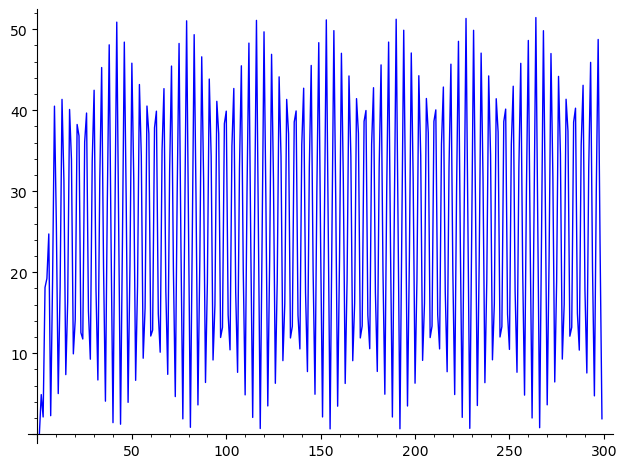

LOGS MINIMUM MODULI


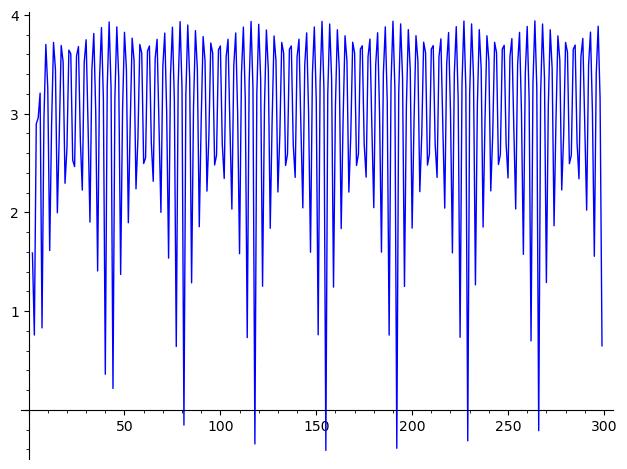

minimum logarithm of minimum modulus: -0.40985664097079214077057014374
Data range: n = 2 to 299
Number of data points: 298
Min modulus range: 0.663745 to 51.440233
Log min modulus range: -0.409857 to 3.940421

Polynomial trend coefficients: [-5.59930205e-06  2.01506668e-03  2.80605589e+00]
Detrended data std dev: 0.9391

TOP DOMINANT PERIODICITIES (in index n)
Rank   Period       Frequency    Power          
----------------------------------------------------------------------
1            4.14   0.241611     1.27e+04
2            2.06   0.486577     3.98e+03
3            3.68   0.271812     1.34e+03
4           37.25   0.026846     1.23e+03


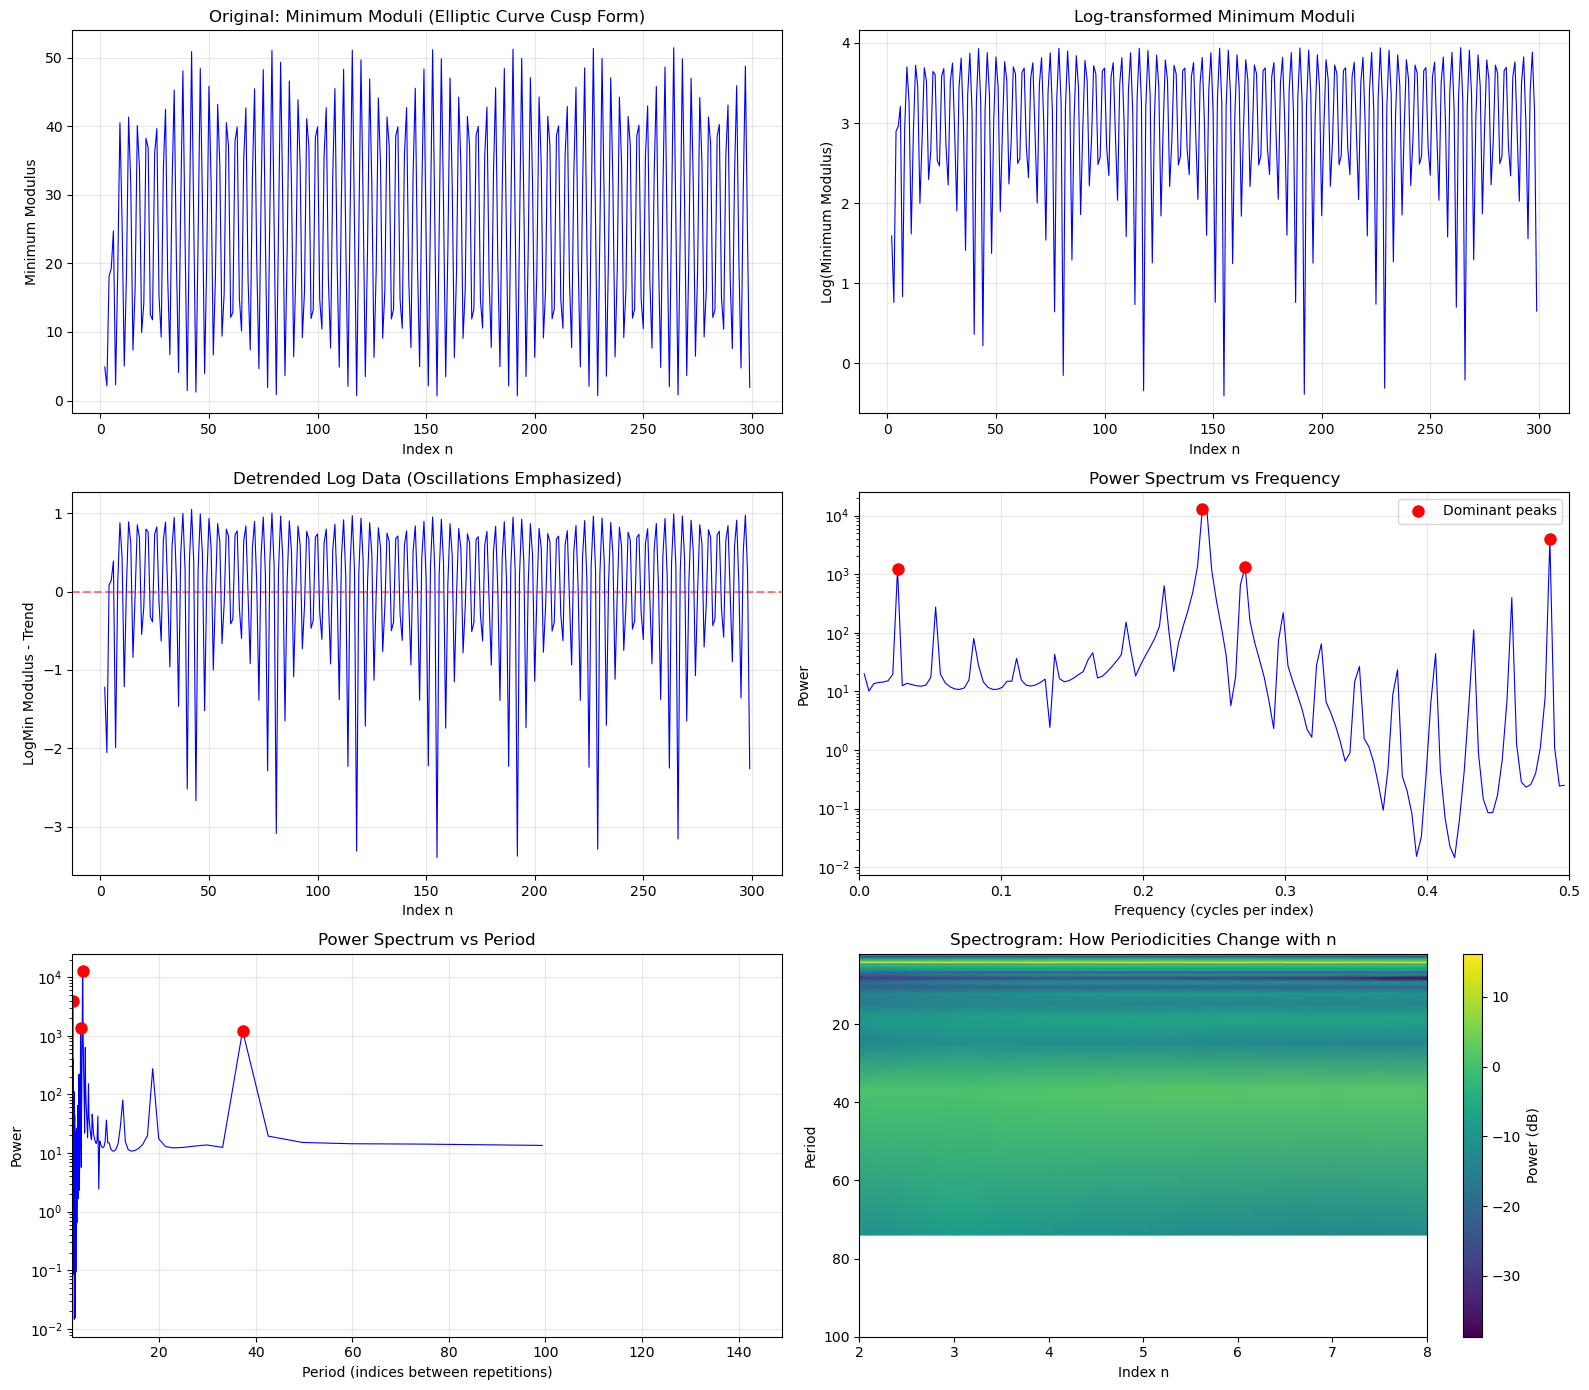


Analysis complete! Examine the plots and frequency table above.


In [8]:
p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
print("MINIMUM MODULI")
p.show()
p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
print("LOGS MINIMUM MODULI")
p.show()
mml=[pair[1] for pair in log_mins_list]
print("minimum logarithm of minimum modulus:",min(mml))



with open('/Users/barrybrent/data2/run3feb26no5.txt', 'wb') as wfile:
    pickle.dump(roots_list, wfile) # ouput snipped


with open('/Users/barrybrent/data2/run3feb26no6.txt', 'wb') as wfile:
    pickle.dump(mins_list, wfile) # ouput snipped

with open('/Users/barrybrent/data2/run3feb6no7.txt', 'wb') as wfile:
    pickle.dump(log_mins_list, wfile) # ouput snipped

# FOURIER ANALYSIS OF MINIMUM MODULI - Elliptic Curve Cusp Form
# This cell performs spectral analysis on the minimum moduli sequence
# to detect periodicities, dominant frequencies, and oscillatory patterns

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PREPARE THE DATA - Convert from SageMath to Python/NumPy types
# ==============================================================================

# Extract the data from mins_list and convert to Python floats
# This is crucial because SageMath uses its own numeric types
indices = np.array([float(pair[0]) for pair in mins_list], dtype=np.float64)
minmoduli = np.array([float(pair[1]) for pair in mins_list], dtype=np.float64)

# Mask out zeros so logs are finite
mask = minmoduli > 0
indices = indices[mask]
minmoduli = minmoduli[mask]
logminmoduli = np.log(minmoduli)

print(f"Data range: n = {int(indices[0])} to {int(indices[-1])}")
print(f"Number of data points: {len(indices)}")
print(f"Min modulus range: {minmoduli.min():.6f} to {minmoduli.max():.6f}")
print(f"Log min modulus range: {logminmoduli.min():.6f} to {logminmoduli.max():.6f}")

# ==============================================================================
# 2. DETRENDING (Important for seeing oscillations)
# ==============================================================================

# For the log data, remove any polynomial trend to focus on oscillations
# We'll try both linear and quadratic detrending

# Linear detrend
log_detrended_linear = signal.detrend(logminmoduli, type='linear')

# Polynomial detrend (degree 2) - captures parabolic growth
poly_coeffs = np.polyfit(indices, logminmoduli, deg=2)
poly_trend = np.polyval(poly_coeffs, indices)
log_detrended_poly = logminmoduli - poly_trend

print(f"\nPolynomial trend coefficients: {poly_coeffs}")
print(f"Detrended data std dev: {np.std(log_detrended_poly):.4f}")

# ==============================================================================
# 3. COMPUTE FOURIER TRANSFORM
# ==============================================================================

# Use FFT on the detrended log data
# The FFT reveals which "frequencies" (periodicities in n) are present

fft_result = np.fft.fft(log_detrended_poly)
fft_frequencies = np.fft.fftfreq(len(indices), d=1.0)  # d=1 means indices are spaced by 1

# Power spectrum (magnitude squared)
power_spectrum = np.abs(fft_result)**2

# Only keep positive frequencies (negative are redundant for real signals)
positive_freq_mask = fft_frequencies > 0
frequencies = fft_frequencies[positive_freq_mask]
power = power_spectrum[positive_freq_mask]

# Convert frequency to period: period = 1/frequency
# (period tells us "spikes repeat every X indices")
periods = 1.0 / frequencies

# ==============================================================================
# 4. IDENTIFY DOMINANT FREQUENCIES
# ==============================================================================

# Find peaks in the power spectrum
# Lower threshold to catch more peaks since we have more data (n up to 400)
peak_indices = signal.find_peaks(power, height=np.max(power)*0.05)[0]  # peaks at least 5% of max
peak_powers = power[peak_indices]
peak_periods = periods[peak_indices]

# Sort by power (strongest first)
sorted_indices = np.argsort(peak_powers)[::-1]
top_peaks = sorted_indices[:min(15, len(sorted_indices))]  # Show top 15

print("\n" + "="*70)
print("TOP DOMINANT PERIODICITIES (in index n)")
print("="*70)
print(f"{'Rank':<6} {'Period':<12} {'Frequency':<12} {'Power':<15}")
print("-"*70)
for rank, idx in enumerate(top_peaks, 1):
    period = peak_periods[idx]
    freq = frequencies[peak_indices[idx]]
    pwr = peak_powers[idx]
    print(f"{rank:<6} {period:>10.2f} {freq:>10.6f} {pwr:>12.2e}")

# ==============================================================================
# 5. VISUALIZATIONS
# ==============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 5.1: Original data (linear scale)
axes[0, 0].plot(indices, minmoduli, 'b-', linewidth=0.8)
axes[0, 0].set_xlabel('Index n')
axes[0, 0].set_ylabel('Minimum Modulus')
axes[0, 0].set_title('Original: Minimum Moduli (Elliptic Curve Cusp Form)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 5.2: Log scale data
axes[0, 1].plot(indices, logminmoduli, 'b-', linewidth=0.8)
axes[0, 1].set_xlabel('Index n')
axes[0, 1].set_ylabel('Log(Minimum Modulus)')
axes[0, 1].set_title('Log-transformed Minimum Moduli')
axes[0, 1].grid(True, alpha=0.3)

# Plot 5.3: Detrended data (shows oscillations more clearly)
axes[1, 0].plot(indices, log_detrended_poly, 'b-', linewidth=0.8)
axes[1, 0].set_xlabel('Index n')
axes[1, 0].set_ylabel('LogMin Modulus - Trend')
axes[1, 0].set_title('Detrended Log Data (Oscillations Emphasized)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 5.4: Power Spectrum vs Frequency
axes[1, 1].semilogy(frequencies, power, 'b-', linewidth=0.8)
axes[1, 1].semilogy(frequencies[peak_indices[top_peaks]],
                    peak_powers[top_peaks],
                    'ro', markersize=8, label='Dominant peaks')
axes[1, 1].set_xlabel('Frequency (cycles per index)')
axes[1, 1].set_ylabel('Power')
axes[1, 1].set_title('Power Spectrum vs Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 0.5)  # Nyquist limit

# Plot 5.5: Power Spectrum vs Period (often more intuitive)
maxperiod = len(indices) / 2  # Only plot periods up to half the data length
periodmask = periods < maxperiod
axes[2, 0].semilogy(periods[periodmask], power[periodmask], 'b-', linewidth=0.8)

# Mark dominant periods
for idx in top_peaks:
    if peak_periods[idx] < maxperiod:
        axes[2, 0].semilogy(peak_periods[idx], peak_powers[idx],
                            'ro', markersize=8)

axes[2, 0].set_xlabel('Period (indices between repetitions)')
axes[2, 0].set_ylabel('Power')
axes[2, 0].set_title('Power Spectrum vs Period')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_xlim(2, maxperiod)

# Plot 5.6: Spectrogram (time-frequency analysis using Short-Time Fourier Transform)
# This shows if periodicities change over the sequence
window_size = min(128, len(indices)//4)  # adaptive window size, larger for more data
fspec, tspec, Sxx = signal.spectrogram(log_detrended_poly, fs=1.0,
                                       nperseg=window_size,
                                       noverlap=window_size//2)

# Convert frequency axis to period for easier interpretation
periodspec = 1.0 / (fspec + 1e-10)  # avoid division by zero
periodspec = periodspec[1:]  # remove DC component
Sxx = Sxx[1:, :]

# Plot with period on y-axis, inverted so small periods at bottom
im = axes[2, 1].pcolormesh(indices[0:len(tspec)], periodspec,
                           10*np.log10(Sxx + 1e-10),
                           shading='gouraud', cmap='viridis')
axes[2, 1].set_xlabel('Index n')
axes[2, 1].set_ylabel('Period')
axes[2, 1].set_title('Spectrogram: How Periodicities Change with n')
axes[2, 1].set_ylim(2, min(100, maxperiod))
axes[2, 1].invert_yaxis()  # small periods at bottom
plt.colorbar(im, ax=axes[2, 1], label='Power (dB)')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Analysis complete! Examine the plots and frequency table above.")
print("="*70)